# AI_campus_ProstateSeg 
# Module 6: Loss function and metrics for semantic segmentation
### PANDA: Prostate cANcer graDe Assessment (PANDA) Challenge

This notebook walks through developing an intuition for the loss functions that can be used to train a semantic segmentation model, in addition to metrics to evaluate the quality of a predicted segmentation mask with respect to a ground truth segmentation mask

## 1. Import the necessary packages

In [1]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import panda_utils as putil
import torch
import torchvision.transforms as transforms

from PIL import Image
from typing import List, Union, Optional, Dict, Tuple
from torch.utils.data import Dataset
from dataclass import ToyPANDASDataset
from torchvision.transforms import functional as F

## 2. Define folder and subdirectory folder names

In [2]:
ROOT_FOLDER = "sample_data"
IMAGE_SUBFOLDER = "train_images"
MASK_SUBFOLDER = "train_label_masks"

image_dir = os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER)
mask_dir = os.path.join(ROOT_FOLDER, MASK_SUBFOLDER)

## 3. Create list of image and mask files and print contents

In [3]:
image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(image_dir))))
mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(mask_dir))))

In [4]:
image_files

['0018ae58b01bdadc8e347995b69f99aa.tiff',
 '004dd32d9cd167d9cc31c13b704498af.tiff',
 '0068d4c7529e34fd4c9da863ce01a161.tiff',
 '006f6aa35a78965c92fffd1fbd53a058.tiff',
 '007433133235efc27a39f11df6940829.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a.tiff',
 '008069b542b0439ed69b194674051964.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff',
 '00951a7fad040bf7e90f32e81fc0746f.tiff',
 '00a26aaa82c959624d90dfb69fcf259c.tiff']

In [5]:
mask_files

['0018ae58b01bdadc8e347995b69f99aa_mask.tiff',
 '004dd32d9cd167d9cc31c13b704498af_mask.tiff',
 '0068d4c7529e34fd4c9da863ce01a161_mask.tiff',
 '006f6aa35a78965c92fffd1fbd53a058_mask.tiff',
 '007433133235efc27a39f11df6940829_mask.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff',
 '008069b542b0439ed69b194674051964_mask.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff',
 '00951a7fad040bf7e90f32e81fc0746f_mask.tiff',
 '00a26aaa82c959624d90dfb69fcf259c_mask.tiff']

## 4. Instantiate PANDA dataset class

From previous module 4, instantiate the PANDA dataset class. The class instantiation process will print out the following metrics for tile processing

- total number of tiles processed over the entire dataset
- tile qualifying ratio (the number of tiles from the total number of tiles that were processed)
- average number of tiles processed per image or mask
- average number of tiles qualifying per image or mask

In [6]:
panda_dataset = ToyPANDASDataset(image_dir = image_dir,
                                 mask_dir = mask_dir,
                                 root_dir = ROOT_FOLDER)

Total number of tiles processed: 38593
Tile qualifying ratio: 0.15458761951649264
Average number of tiles processed per image or mask: 3859.3
Average number of tiles qualifying per image or mask: 596.6


Print out the length of the dataset class, this will return the number of qualifying tiles over the entire dataset, which is the number of tuples contained in the imtile_coords list in the dataset class.

In [7]:
len(panda_dataset)

5966

Access one element of the dataset class, which will call the __getitem__ method. It returns a single, non-batched data point, which is a tile of dimensionality (224, 224, 3)

In [9]:
panda_dataset[0].shape

(224, 224, 3)

Plot one of the tiles

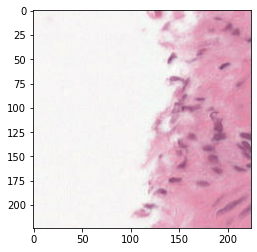

In [10]:
plt.imshow(panda_dataset[10])

## 5. Cross entropy loss function intuition

In semantic image segmentation, our goal is to classify each pixel of an image into one of a few class, in case of multi-class semantic segmentation. Generally, the cross entropy loss function is used for multi-class classification tasks. Given a ground truth, target one-hot vector, and a predicted probability distribution over a few classes that a pixel could belong to, the cross entropy loss function is high when the predicted probability distribution is very different with respect to the ground truth probability distribution, and it is low when the predicted probability distribution is very similar to the ground truth probability distribution. The cross entropy loss function is defined as follows:

$\text{CE}(p, q) = - \sum_{c=1}^{C} y_c \log(p_c)$


Write code for cross entropy loss function

In [11]:
def ce_loss(true, predicted):
    
    assert len(true) == len(predicted)
    loss = 0.0
    
    for i in range(len(true)):
        loss += true[i]*np.log(predicted[i])
    
    return -loss

We can compare examples of distribution pairs in order to develop an intuition for this loss function. In the following example, there is a supremum distance of 0.1 = (1.0 - 0.9).

In [24]:
true = [1.0, 0.0, 0.0]
predicted = [0.9, 0.5, 0.5]

In [27]:
print(f"CE Loss: {round(ce_loss(true, predicted),2)}")

CE Loss: 0.11


In the following example, there is a higher supremum distance of 0.2 (1.0 - 0.8), the probability distributions are more different, and hence, we observe a higher cross entropy loss.

In [30]:
true = [1.0, 0.0, 0.0]
predicted = [0.8, 0.1, 0.2]

In [31]:
print(f"CE Loss: {round(ce_loss(true, predicted),2)}")

CE Loss: 0.22


In the following example, there is a supremum distance of 0.5 (1.0 - 0.5), the probability distributions are more different than the previous example, and hence, we observe a higher cross entropy loss.

In [33]:
true = [1.0, 0.0, 0.0]
predicted = [0.5, 0.25, 0.25]

In [34]:
print(f"CE Loss: {round(ce_loss(true, predicted),2)}")

CE Loss: 0.69


In the following example, there is a supremum distance of 0.9 (1.0-0.1), the probability distributions are more different than the previous example, and hence, we observe a higher cross entropy loss.

In [35]:
true = [1.0, 0.0, 0.0]
predicted = [0.1, 0.8, 0.1]

In [36]:
print(f"CE Loss: {round(ce_loss(true, predicted),2)}")

CE Loss: 2.3


The CE loss tends to larger and larger values as the difference in the probability distributions increases.

In [41]:
true = [1.0, 0.0, 0.0]
predicted = [0.01, 0.495, 0.495]

In [49]:
print(f"CE Loss: {round(ce_loss(true, predicted),2)}")

CE Loss: 4.61


## 6. Intersection over Union for comparing predicted segmentation mask with respect to ground truth segmentation mask

Another way to evaluate the similarity between a predicted segmentation mask and a ground truth binary or multi-class segmentation mask is through the intersection over union metric. This metric compares the overlap between a ground truth segmentation mask and a predicted segmentation mask. It is defined by the following formula. The numerator is the number of intersecting pixels in both the masks (number of points where there is a 1 in both the masks) and the denominator is the number of pixels that are 1 in either the ground truth mask or the predicted mask.

$\text{IoU} = \frac{|A \cap B|}{|A \cup B|}$

If the two masks being compared: the ground truth mask and the predicted mask, are binary (i.e. contain only 0s or 1s), then the following function can be used to calculate the IOU by flattening the 2D matrices to 1D vectors.

In [53]:
def compute_iou(mask1: np.ndarray, 
                mask2: np.ndarray) -> float:
    """
    Compute the intersection over union (IoU) between two
    binary masks. 
    
    Parameters
    ----------
    mask1: np.ndarray
        Binary mask of shape (H, W)
    
    mask2: np.ndarray
        Binary mask of shape (H, W)
    
    Returns
    --------
    float:
        The intersection over union (IoU) score
        between the two binary masks
    """
    
    mask1 = mask1.flatten()
    mask2 = mask2.flatten()
    
    intersection = np.dot(mask1, mask2)
    union = np.sum(mask1) + np.sum(mask2) - intersection
    
    return intersection / union

Example of binary mask pair with high intersection over union

In [58]:
mask1_high = np.array([[1, 1, 0], [1, 1, 0], [0, 0, 0]])
mask2_high = np.array([[1, 1, 0], [1, 1, 0], [0, 0, 0]])

In [59]:
mask1_high

array([[1, 1, 0],
       [1, 1, 0],
       [0, 0, 0]])

In [60]:
mask2_high

array([[1, 1, 0],
       [1, 1, 0],
       [0, 0, 0]])

In [61]:
compute_iou(mask1_high, mask2_high)

1.0

Example of binary mask pair with moderate intersection over union

In [62]:
mask1_moderate = np.array([[1, 1, 0], [1, 1, 0], [0, 0, 0]])
mask2_moderate = np.array([[1, 0, 0], [1, 0, 0], [1, 1, 0]])

In [63]:
mask1_moderate

array([[1, 1, 0],
       [1, 1, 0],
       [0, 0, 0]])

In [64]:
mask2_moderate

array([[1, 0, 0],
       [1, 0, 0],
       [1, 1, 0]])

In [65]:
compute_iou(mask1_moderate, mask2_moderate)

0.3333333333333333

Example of binary mask pair with low intersection over union

In [66]:
mask1_low = np.array([[1, 1, 0], [1, 1, 0], [0, 0, 0]])
mask2_low = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 1]])

In [67]:
mask1_low

array([[1, 1, 0],
       [1, 1, 0],
       [0, 0, 0]])

In [68]:
mask2_low

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 1]])

In [69]:
compute_iou(mask1_low, mask2_low)

0.0